In [61]:
from dataset import PolicyDataset
import torch
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from torchvision.transforms.functional_tensor import resize
from torch import nn
from captum.attr import IntegratedGradients, GradientShap, Saliency
from captum.attr import visualization as viz
from play import  _load_checkpoint

In [2]:
class AtariNet(nn.Module):
    """ Estimator used by DQN-style algorithms for ATARI games.
        Works with DQN, M-DQN and C51.
    """
    def __init__(self, action_no, distributional=False):
        super().__init__()

        self.action_no = out_size = action_no
        self.distributional = distributional

        # configure the support if distributional
        if distributional:
            support = torch.linspace(-10, 10, 51)
            self.__support = nn.Parameter(support, requires_grad=False)
            out_size = action_no * len(self.__support)

        # get the feature extractor and fully connected layers
        self.__features = nn.Sequential(
            nn.Conv2d(4, 32, kernel_size=8, stride=4),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(inplace=True),
        )
        self.__head = nn.Sequential(
            nn.Linear(64 * 7 * 7, 512), nn.ReLU(inplace=True), nn.Linear(512, out_size),
        )

    def forward(self, x):
        x = x.float()

        x = self.__features(x)
        qs = self.__head(x.view(x.size(0), -1))

        if self.distributional:
            logits = qs.view(qs.shape[0], self.action_no, len(self.__support))
            qs_probs = torch.softmax(logits, dim=2)
            return torch.mul(qs_probs, self.__support.expand_as(qs_probs)).sum(2)
        return qs

In [62]:
dataset = PolicyDataset('/scratchdata/s3092593/tmp/train', prepare=False)

In [63]:
def plot_saliency(i, file_name, model):
    inp, gt, action = dataset[i]
    inp.requires_grad = True
    output = model(inp.cpu().float().unsqueeze(0))
    output_for_act = output[0, action]
    output_for_act.backward()
    slc = torch.abs(inp.grad)[-1]
    slc = (slc - slc.min()) / (slc.max() - slc.min())
    hmap = resize(torch.concat([slc.unsqueeze(0), torch.zeros(2, 84, 84)], dim=0), [210, 160]).permute(1, 2, 0).detach().numpy()
    eid, fid, gt, action = dataset.data[i]
    print(f'{dataset.root_dir}/e{eid}_f{fid}.png')
    plt.imshow((np.array(Image.open(f'{dataset.root_dir}/e{eid}_f{fid}.png')).astype(np.float32) + hmap.astype(np.float32) * 255).astype(np.uint8))
    plt.axis('off')
    plt.savefig(file_name, bbox_inches='tight')


/scratchdata/s3092593/tmp/train/e745_f549.png
/scratchdata/s3092593/tmp/train/e745_f549.png
/scratchdata/s3092593/tmp/train/e745_f549.png
/scratchdata/s3092593/tmp/train/e745_f549.png
/scratchdata/s3092593/tmp/train/e745_f549.png
/scratchdata/s3092593/tmp/train/e745_f549.png


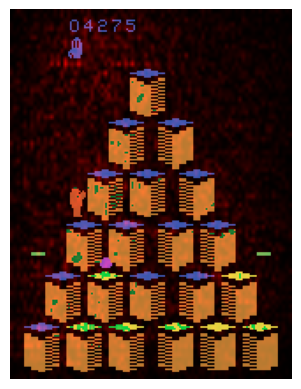

In [64]:
archs1 = ['dueling', 'nature', 'impala_large:1', 'impala_large:2', 'impala_large:4', 'impalanextv2_large:2']
archs2 = ['dueling', 'nature', 'impala_large_1', 'impala_large_2', 'impala_large_4', 'impalanextv2_large_2']

for arch1, arch2 in zip(archs1, archs2):

    model = torch.load(f'/data1/s3092593/saved_benchmarks/benchmark_final_{arch1}_MDQN_modern_Qbert_model_50000000_0_{arch2}_0.pt').cpu()
    for param in model.parameters():
        param.requires_grad = False
    plot_saliency(510020, f'qbert_model_50000000_0_{arch1}_0_bench.png', model)

/scratchdata/s3092593/tmp/train/e745_f549.png


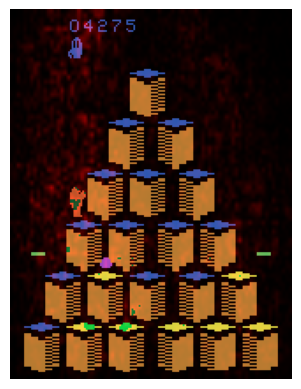

In [65]:

# init model
model = AtariNet(6, False)

# load state
ckpt = _load_checkpoint('/data1/s3092593/atari_agents/ale_agents/MDQN_modern/Qbert/0/model_50000000.gz')
model.load_state_dict(ckpt["estimator_state"])
for param in model.parameters():
    param.requires_grad = False
plot_saliency(510020, 'qbert_model_50000000_0_dueling_0_mdqn.png', model)

/scratchdata/s3092593/tmp/train/e745_f549.png


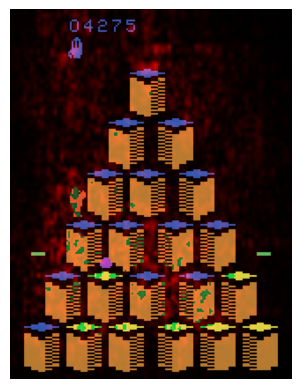

In [66]:

# init model
model = AtariNet(6, False)

# load state
ckpt = _load_checkpoint('/data1/s3092593/atari_agents/ale_agents/DQN_modern/Qbert/0/model_50000000.gz')
model.load_state_dict(ckpt["estimator_state"])
for param in model.parameters():
    param.requires_grad = False
plot_saliency(510020, 'qbert_model_50000000_0_dueling_0_dqn.png', model)

In [67]:
torch.manual_seed(0)
np.random.seed(0)

In [68]:
model = torch.load(f'/data1/s3092593/saved_benchmarks/benchmark_final_dueling_MDQN_modern_Qbert_model_50000000_0_dueling_0.pt').cpu()
model.eval()

DuelingNatureCNN(
  (main): Sequential(
    (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
  )
  (dueling): Dueling(
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (value_branch): Sequential(
      (0): Linear(in_features=3136, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=1, bias=True)
    )
    (advantage_branch): Sequential(
      (0): Linear(in_features=3136, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=6, bias=True)
    )
  )
)

In [69]:
inp, gt, action = dataset[0]
eid, fid, gt, action = dataset.data[0]
print(f'{dataset.root_dir}/e{eid}_f{fid}.png')

/scratchdata/s3092593/tmp/train/e0_f889.png


In [70]:
gradient_shap = GradientShap(model)

In [71]:
inp = inp.unsqueeze(0).float()

In [72]:
rng_img_dist = torch.cat([torch.zeros(1, 4, 84, 84), torch.ones(1, 4, 84, 84)], dim=0)

In [73]:
attributions_gs = gradient_shap.attribute(inp, target=action, baselines=rng_img_dist, n_samples=5000, stdevs=0.0001, return_convergence_delta=True)

In [74]:
attributions_gs[0].squeeze(0).shape

torch.Size([4, 84, 84])

In [75]:
np.moveaxis(np.array(Image.open(f'{dataset.root_dir}/e{eid}_f{fid}.png')), 2, 0).shape

(3, 210, 160)

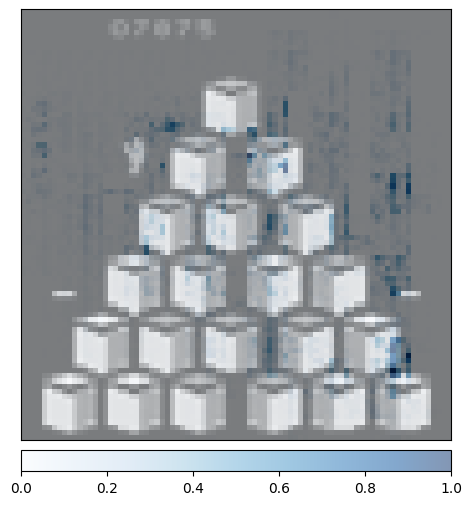

In [76]:
_ = viz.visualize_image_attr(np.transpose(attributions_gs[0].squeeze().cpu().detach().numpy()), 
                             np.array(Image.open(f'{dataset.root_dir}/e{eid}_f{fid}.png').resize((84, 84))), 
                             method="blended_heat_map", sign="absolute_value", show_colorbar=True, outlier_perc=1)

In [77]:
att = IntegratedGradients(model).attribute(inp, target=action, baselines=0, n_steps=5000)

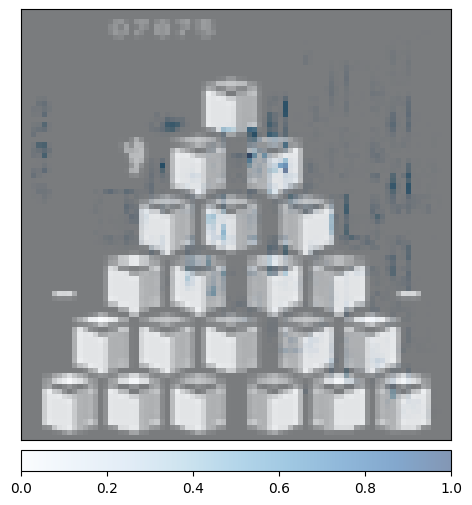

In [78]:
_ = viz.visualize_image_attr(np.transpose(att.squeeze().cpu().detach().numpy()), 
                             np.array(Image.open(f'{dataset.root_dir}/e{eid}_f{fid}.png').resize((84, 84))), 
                             method="blended_heat_map", sign="absolute_value", show_colorbar=True, outlier_perc=1)

In [80]:
att = Saliency(model).attribute(inp, target=action)

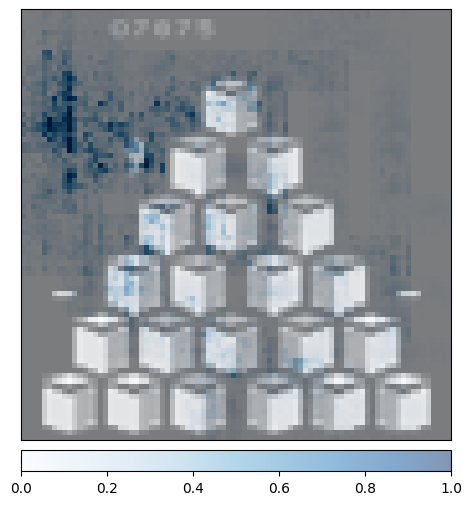

In [81]:
_ = viz.visualize_image_attr(np.transpose(att.squeeze().cpu().detach().numpy()), 
                             np.array(Image.open(f'{dataset.root_dir}/e{eid}_f{fid}.png').resize((84, 84))), 
                             method="blended_heat_map", sign="absolute_value", show_colorbar=True, outlier_perc=1)